# LLMs with tools

In [1]:
import numpy as np
import pandas as pd
import math
import json
import re
import os
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from dotenv import load_dotenv
from pymatgen.core.composition import Composition
from pymatgen.ext.matproj import MPRester

In [2]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

OPENAI_MODEL="gpt-4o" # "gpt-3.5-turbo", "gpt-4o-mini", "gpt-4o"
# see the list of availible models https://platform.openai.com/docs/models
load_dotenv()
openai_api_key = os.environ.get('OPENAI_API_KEY')
mp_api_key = os.environ.get('MP_API_KEY')

In [3]:
from langchain_community.tools import TavilySearchResults

tavily_api_key = os.environ["TAVILY_API_KEY"]
search_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

In [4]:
from typing import Annotated, TypedDict, Dict
from langchain.agents import tool
from mp_api.client import MPRester


@tool
def MP_get_structure(compound: str, primitive="False") -> Dict:
    """ 
    Function requests structures for all stable entries available in Materials Project via MPRester() for the compound.
    And generates: (1) the list of atomic positions in cartesian coordinates, in Angstrom
                   (2) the string with the coordinates of vectors for the unit cell. 
                   The coordinates of vectors are given in Angstrom
    Args:
        compound: str -> formula of the compound
        primitive: bool -> whether to transform the unit cell into primitive or use conventional
    """
    with MPRester(mp_api_key) as mpr:
        docs = mpr.materials.summary.search(
            formula=compound, is_stable="True"
        ) 
    struct=docs[0].structure
    if(not primitive):
        atomic_coordinates=''
        cell_vectors=''
        for site in struct.sites:
           line = str(site.specie)
           for x in site.coords:
               line+=' '+str(x)
           atomic_coordinates+=line+'\n'
        for vec in struct.lattice.matrix:
           line=str(vec[0])+' '+str(vec[1])+' '+str(vec[2])+'\n'
           cell_vectors+=line
        return { 'list_of_atomic_coordinates': atomic_coordinates, 'list_of_cell_vectors': cell_vectors}
    else:
        primitive_cell=SpacegroupAnalyzer(struct)
        primitive_cell=primitive_cell.get_primitive_standard_structure()
        atomic_coordinates_primitive=''
        primitive_cell_vectors=''
        for site in primitive_cell.sites:
           line = str(site.specie)
           for x in site.coords:
               line+=' '+str(x)
           atomic_coordinates_primitive+=line+'\n'
        for vec in primitive_cell.lattice.matrix:
           line=str(vec[0])+' '+str(vec[1])+' '+str(vec[2])+'\n'
           primitive_cell_vectors+=line
        return  { 'list_of_atomic_coordinates': atomic_coordinates_primitive, 'list_of_cell_vectors': primitive_cell_vectors}

@tool
def dir_name(pseudo_potentials_folder: str,
             functional: str, 
             mode: str) -> str:
    '''
    Function to determine the path to the folder with the correct pseudopotentials
    Args: 
         pseudo_potentials_folder: str, name of the parent forlder with pseudopotentials
         functional: str, name of the DFT functional
         mode: str, mode for pseudopotential, list of possible values: ["efficiency", "precision"]
    '''
    list_of_subfolders=os.listdir(pseudo_potentials_folder)
    for subfolder in list_of_subfolders:
        if(re.search(functional.lower()+"_", subfolder.lower()) and re.search(mode.lower(), subfolder.lower())):
            return pseudo_potentials_folder+"/"+subfolder+"/"

@tool
def list_of_pseudos(pseudo_potentials_folder: str, 
                    functional: str,
                    mode: str, 
                    compound: str) -> list:
    '''
    Function to determine the list of names of files with pseudopotentials for the compound
    Args:
        pseudo_potentials_folder: str, name of the parent forlder with pseudopotentials
        functional: str, name of the DFT functional
        mode: str, mode for pseudopotential, list of possible values: ["efficiency", "precision"]
        compound: str, composition of the compound
    '''
    list_of_subfolders=os.listdir(pseudo_potentials_folder)
    for subfolder in list_of_subfolders:
        if(re.search(functional.lower()+"_", subfolder.lower()) and re.search(mode.lower(), subfolder.lower())):
            list_of_files=os.listdir(pseudo_potentials_folder+"/"+subfolder+"/")
    #print('The list of pseudo files is: ', list_of_files[0], ', ...')
    #print(list_of_files)
    list_of_element_files=[]
    for file in list_of_files:
        for element in Composition(compound).elements:
            element=str(element).lower()
            if(file[:len(element)].lower()==element and not file[len(element):len(element)+1].lower().isalpha()):
                list_of_element_files.append(file)
                
    return list_of_element_files

@tool
def cutoff_limits(pseudo_potentials_cutoffs_folder: str, 
                  functional: str,
                  mode: str,
                  compound: str) -> Dict:
    '''
    Function to determine the maximum energy cutoff and density cutoff possible based on cutoff values specified for pseudopotentials
    Args:
        pseudo_potentials_cutoffs: str, the main folder with pseudopotential cutoffs
        functional: str, name of the DFT functional
        mode: str, mode for pseudopotential, list of possible values: ["efficiency", "precision"]
        compound: str, composition of the compound
    Output:
        Dictionary with keys 'max_ecutwfc' and 'max_ecutrho' and float values
    '''
    list_of_cutoff_files=os.listdir(pseudo_potentials_cutoffs_folder)
    for file in list_of_cutoff_files:
        if(re.search(functional.lower()+"_", file.lower()) and re.search(mode.lower(), file.lower())):
            try:
                with open(pseudo_potentials_cutoffs_folder+"/"+file, "r") as f:
                    cutoffs=json.load(f)
            except:
                cutoffs={}
    elements=[str(el) for el in Composition(compound).elements]
    if(cutoffs!={}):
        subset={key:cutoffs[key] for key in elements}
        encutoffs=[subset[i]['cutoff_wfc'] for i in subset.keys()]
        rhocutoffs=[subset[i]['cutoff_rho'] for i in subset.keys()]
        max_ecutoff=min(encutoffs)
        max_rhocutoff=min(rhocutoffs)
    else:
        max_ecutoff=np.nan
        max_rhocutoff=np.nan
    return { 'max_ecutwfc': max_ecutoff, 'max_ecutrho': max_rhocutoff}

def generate_kpoints_grid(lattice, k_density):
    #kpoints = Kpoints.automatic_density(lattice, k_density)
    kpoints = [math.ceil(k_density/x) for x in lattice.abc]
    kpoints.extend([0,0,0])
    return points

@tool
def get_formula(cif_file: str, primitive=False) -> str:
    '''
    Function reads the formula of the compound from structure file
    Args:
        cif_file: str, structure file
        primitive: bool, whether to transform the unit cell to the primitive one or not
    '''
    struct=Structure.from_file(cif_file)
    if(not primitive):
        return struct.formula
    else:
        primitive_struct=SpacegroupAnalyzer(struct)
        primitive_struct=primitive_struct.get_primitive_standard_structure()
        return primitive_struct.formula

@tool
def get_list_of_atomic_positions(cif_file: str, primitive=False) -> str:
    '''
    This function reads the structure file and returns the string with all atomic positions. 
    Atomic positions are in cartesian coordinates, in Angstrom
    Args:
        cif_file: str, structure file
        primitive: bool, whether to transform the unit cell to the primitive one or not
    '''
    struct = Structure.from_file(cif_file)
    if(not primitive):
        atomic_coordinates=''
        for site in struct.sites:
           line = str(site.specie.element)
           for x in site.coords:
               line+=' '+str(x)
           atomic_coordinates+=line+'\n'
        return atomic_coordinates
    else:
        primitive_cell=SpacegroupAnalyzer(struct)
        primitive_cell=primitive_cell.get_primitive_standard_structure()
        atomic_coordinates_primitive=''
        for site in primitive_cell.sites:
           line = str(site.specie.element)
           for x in site.coords:
               line+=' '+str(x)
           atomic_coordinates_primitive+=line+'\n'
        return atomic_coordinates_primitive

@tool
def get_cell_vectors(cif_file: str, primitive: bool = False) -> str:
    '''
    This function reads the structure file and returns the string with the coordinates of vectors for the unit cell. 
    Coordinates of vectors are given in Angstrom
    Args:
        cif_file: str, structure file
        primitive: bool, whether to transform the unit cell to the primitive one or not
    '''
    struct = Structure.from_file(cif_file)
    if(not primitive):
        cell_vectors=''
        for vec in struct.lattice.matrix:
           line=str(vec[0])+' '+str(vec[1])+' '+str(vec[2])+'\n'
           cell_vectors+=line
        return cell_vectors
    else:
        primitive_cell=SpacegroupAnalyzer(struct)
        primitive_cell=primitive_cell.get_primitive_standard_structure()
        primitive_cell_vectors=''
        for vec in primitive_cell.lattice.matrix:
           line=str(vec[0])+' '+str(vec[1])+' '+str(vec[2])+'\n'
           primitive_cell_vectors+=line
        return primitive_cell_vectors


def get_formula_nottool(cif_file: str, primitive=False) -> str:
    '''
    Function reads the formula of the compound from structure file
    Args:
        cif_file: str, structure file
        primitive: bool, whether to transform the unit cell to the primitive one or not
    '''
    struct=Structure.from_file(cif_file)
    if(not primitive):
        return struct.formula
    else:
        primitive_struct=SpacegroupAnalyzer(struct)
        primitive_struct=primitive_struct.get_primitive_standard_structure()
        return primitive_struct.formula

/opt/miniconda3/envs/llm/lib/python3.12/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/opt/miniconda3/envs/llm/lib/python3.12/site-packages/paramiko/transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [5]:
llm = ChatOpenAI(model=OPENAI_MODEL)
tools=[MP_get_structure,dir_name, list_of_pseudos, cutoff_limits, get_formula, get_list_of_atomic_positions, get_cell_vectors, search_tool]
llm_with_tools = llm.bind_tools(tools)

In [6]:
structure_dir="structure_files"
pseudo_potentials_folder = "pseudos"
pseudo_potentials_cutoffs_folder = "pseudo_cutoffs"
compound = "Al2O3"
cif_file=structure_dir+"/"+"Al2O3_ICSD_009770.cif"
functional = "PBE" # the available values are "PBE" and "PBESol"
mode = "efficiency" # the available values "efficiency" and "precision"
primitive=True
try:
    compound = get_formula_nottool(cif_file, primitive)
except: 
    pass

In [7]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant helping to generate input files for Quantum Espresso \
                                for single point energy calculations.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

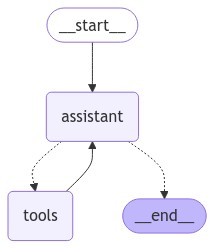

In [9]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
prompt1 = ChatPromptTemplate.from_messages(
    [
        (
            "human", "Can you generate the Quantum Espresso input file for compound {compound} for energy calculation \
            for {functional} functional and {mode} mode? \
            The name of the parent folder with pseudopotentials is {pseudo_potentials_folder}.\
            Determine the path to the folder with the correct pseudopotentials.\
            Get the list of names of files with pseudopotentials for the compound.\
            The directory with cutoffs is {pseudo_potentials_cutoffs_folder}. \
            Read the structure file {cif_file} to determine formula, atomic positions and unit cell vectors.\
            Choose a conventional unit cell if {primitive} is False, and convert it to primitive cell if {primitive} is True. \
            Check that the energy cutoff and density cutoff are not larger than the maximum cutoff values \
            for pseudopotentials used.\
            Now generate the Quantum Espresso input file for {compound}."
        ),
    ]
)

In [ ]:
prompt2 = ChatPromptTemplate.from_messages(
    [
        (
            "human", "Can you generate the Quantum Espresso input file for compound {compound} for 'scf' energy calculation \
            for {functional} functional and {mode} mode? \
            Think about the information you need to have. Generate an action plan. Use the tools provided. End with generating \
            the input file.  Do not forget to include ATOMIC_SPECIES, ATOMIC_POSITIONS, CELL_PARAMETERS (cell vectors), and K_POINTS cards.\
            After generation critically assess whether it is correct and correct mistakes if there are any. Pay attention to (1) the \
            compatibility of structure parameters in &SYSTEM and ATOMIC_POSITIONS and CELL_PARAMETERS,\
            (2) parameters in &CONTROL which are not needed for 'scf' calculation.\
            Input information: compound {compound}, parent folder with pseudo potentials {pseudo_potentials_folder}, \
            folder with cutoffs for pseudopotentials is {pseudo_potentials_cutoffs_folder}, mode is {mode}, \
            functional is {functional}, structure file is {cif_file}, convert to the primitive cell if {primitive} is True.\
           "
        ),
    ]
)

In [11]:
prompt3 = ChatPromptTemplate.from_messages(
    [
        (
            "human", "Can you generate the Quantum Espresso input file for compound {compound} for 'scf' energy calculation \
            for {functional} functional and {mode} mode? \
            Think about the information you need to have. Generate an action plan. Use the tools provided. End with generating \
            the input file.  Do not forget to include ATOMIC_SPECIES, ATOMIC_POSITIONS, CELL_PARAMETERS (cell vectors), and K_POINTS cards.\
            After generation critically assess whether it is correct and correct mistakes if there are any. Pay attention to (1) the \
            compatibility of structure parameters in &SYSTEM and ATOMIC_POSITIONS and CELL_PARAMETERS,\
            (2) parameters in &CONTROL which are not needed for 'scf' calculation. \
            (3) Is the compound {compound} metallic? Does it nead smearing? (4) is the compound {compound} magnetic, \
            does it need spin-polarised calculations?\
            Input information: compound {compound}, parent folder with pseudo potentials {pseudo_potentials_folder}, \
            folder with cutoffs for pseudopotentials is {pseudo_potentials_cutoffs_folder}, mode is {mode}, \
            functional is {functional}, structure file is {cif_file}, convert to the primitive cell if {primitive} is True.\
           "
        ),
    ]
)

In [ ]:
prompt4 = ChatPromptTemplate.from_messages(
    [
        (
            "human", "Can you generate the Quantum Espresso input file for compound {compound} for 'scf' energy calculation \
            for {functional} functional and {mode} mode? Use the structure from Materials Project. \
            Think about the information you need to have. Generate an action plan. Use the tools provided. End with generating \
            the input file.  Do not forget to include ATOMIC_SPECIES, ATOMIC_POSITIONS, CELL_PARAMETERS (cell vectors), and K_POINTS cards.\
            After generation critically assess whether it is correct and correct mistakes if there are any. Pay attention to (1) the \
            compatibility of structure parameters in &SYSTEM and ATOMIC_POSITIONS and CELL_PARAMETERS,\
            (2) parameters in &CONTROL which are not needed for 'scf' calculation. \
            (3) Is the compound {compound} metallic? Does it nead smearing? (4) is the compound {compound} magnetic, \
            does it need spin-polarised calculations?\
            Input information: compound {compound}, parent folder with pseudo potentials {pseudo_potentials_folder}, \
            folder with cutoffs for pseudopotentials is {pseudo_potentials_cutoffs_folder}, mode is {mode}, \
            functional is {functional}, structure download from Materials Project, convert to the primitive cell if {primitive} is True.\
           "
        ),
    ]
)

In [ ]:
prompt4 = ChatPromptTemplate.from_messages(
    [
        (
            "human", "Can you generate python code to generate input file for quantum espresso for compound {compound} for single point \
            energy calculations with {functional} functional and {mode} mode? \
            Read the structure from {cif_file}. Use write_espresso_in function from ASE."
        ),
    ]
)

In [10]:
prompt4 = ChatPromptTemplate.from_messages(
    [
        (
            "human", "Can you generate python code to generate input file for quantum espresso for compound {compound} for single point \
            energy calculations with {functional} functional and {mode} mode? \
            Read the structure from {cif_file}. Use AiiDA Quantum espresso plugin to do it."
        ),
    ]
)

In [11]:
messages=prompt4.invoke(
    { 
        "compound": compound,
        "pseudo_potentials_folder": pseudo_potentials_folder,
        "pseudo_potentials_cutoffs_folder": pseudo_potentials_cutoffs_folder,
        "mode": mode,
        "functional": functional, 
        "cif_file": cif_file,
        "primitive": primitive, 
    }
).messages

In [12]:
messages = react_graph.invoke({"messages": messages})

In [13]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Can you generate python code to generate input file for quantum espresso for compound Al4 O6 for single point             energy calculations with PBE functional and efficiency mode?             Read the structure from structure_files/Al2O3_ICSD_009770.cif. Use AiiDA Quantum espresso plugin to do it.
================================== Ai Message ==================================

Certainly! Below is a Python code snippet that uses the AiiDA Quantum ESPRESSO plugin to generate an input file for a single point energy calculation for the compound Al4O6 using the PBE functional and efficiency mode. The structure is read from the specified CIF file.

```python
from aiida.engine import run
from aiida.orm import Code, StructureData, Dict
from aiida.plugins import CalculationFactory
from pymatgen.io.cif import CifParser

# Load structure from CIF file
cif_file = 'structure_files/Al2O3_ICSD_009770.cif'
parser = C

In [ ]:
with open('generated_files_test2/prompt4_'+OPENAI_MODEL+'_'+compound.replace(' ','_')+'_scf.txt','w') as f:
    for m in messages['messages']:
        f.write(m.content+'\n')

In [13]:
from ase import Atoms
from ase.io.espresso import write_espresso_in
from ase.build import bulk
import os

# Parameters
compound = 'Ti'
functional = 'PBE'
mode = 'efficiency'
pseudo_potentials_folder = 'pseudopotentials'
pseudo_potentials_cutoffs_folder = 'pseudo_cutoffs'

# Create a bulk structure for Titanium
structure = bulk('Ti', 'hcp', a=2.95, c=4.683)

# Define the pseudopotentials directory and filename
pseudo_dir = os.path.join(pseudo_potentials_folder, functional, mode)
pseudo_filename = os.path.join(pseudo_dir, f'{compound}.UPF')

# Define calculation parameters
control = {
    'calculation': 'scf',
    'restart_mode': 'from_scratch',
    'pseudo_dir': pseudo_dir,
    'outdir': './output',
    'prefix': 'Ti',
    'verbosity': 'high'
}

system = {
    'ecutwfc': 40,  # Planewave cutoff
    'ecutrho': 320, # Density cutoff
    'occupations': 'smearing',
    'smearing': 'mv',
    'degauss': 0.02
}

electrons = {
    'conv_thr': 1.0e-8,
    'mixing_beta': 0.7
}

# Create the input file
input_filename = 'Ti_scf.in'
write_espresso_in(input_filename, structure,
                  pseudopotentials={compound: pseudo_filename},
                  control=control, system=system, electrons=electrons)

print(f"Quantum Espresso input file '{input_filename}' generated.")

Quantum Espresso input file 'Ti_scf.in' generated.


In [22]:
from ase.io import read
from ase.io.espresso import write_espresso_in

# Read the structure from the CIF file
c

# Define the pseudopotentials
pseudopotentials = {
    'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF',  # Replace with the actual filename
    'O': 'O.pbe-n-kjpaw_psl.1.0.0.UPF'    # Replace with the actual filename
}

# Define the calculation parameters
control = {
    'calculation': 'scf',
    'restart_mode': 'from_scratch',
    'prefix': 'Al4O6',
    'pseudo_dir': './pseudopotentials',  # Directory containing pseudopotentials
    'outdir': './out'  # Output directory
}

system = {
    'ecutwfc': 40,  # Replace with the actual value
    'ecutrho': 320  # Replace with the actual value
}

# Write the Quantum Espresso input file
write_espresso_in('Al4O6.in', structure, pseudopotentials=pseudopotentials,
                  control=control, system=system)

In [35]:
from aiida.engine import run
from aiida.orm import Code, StructureData, Dict
from aiida.plugins import CalculationFactory
from pymatgen.io.cif import CifParser
from aiida import load_profile
from ase.io import read
from aiida.orm import load_code

load_profile()

# Load structure from CIF file
cif_file = 'structure_files/Al2O3_ICSD_009770.cif'
structure = read('structure_files/Al2O3_ICSD_009770.cif')

# Convert pymatgen structure to AiiDA StructureData
structure_data = StructureData(ase=structure)

# Prepare input parameters for the calculation
parameters = Dict(dict={
    'CONTROL': {
        'calculation': 'scf',
        'verbosity': 'high',
    },
    'SYSTEM': {
        'ecutwfc': 30,  # You might want to adjust this based on pseudopotential
        'ecutrho': 240, # Generally 8*ecutwfc
    },
    'ELECTRONS': {
        'conv_thr': 1.0e-8,
    }
})

# Set up pseudopotentials (ensure pseudopotentials are available in your setup)
pseudo_family = 'SSSP_efficiency_PBE'

# Load the Quantum ESPRESSO code
qe_code = load_code(label='pw@qe-computer')  # Make sure to replace with your code label

# Create the calculation builder
PwCalculation = CalculationFactory('quantumespresso.pw')
builder = PwCalculation.get_builder()
builder.code = qe_code
builder.structure = structure_data
builder.parameters = parameters
builder.pseudos = pseudo_family
builder.metadata.options.resources = {'num_machines': 1}
builder.metadata.options.max_wallclock_seconds = 3600

# Run the calculation
# results = run(builder)

# # Access the output
# output_parameters = results['output_parameters']
# print("Calculation completed successfully.")
# print("Output parameters:", output_parameters)

TypeError: port namespace `pseudos` received `<class 'str'>` instead of a dictionary